Besides other reflections, which I'll copy below this for good measure, maybe let's make things simple, well, relatively, and see how we do when we make gendered models... we saw how vastly different each were, plus would be relatively easy...

"Aww, when I submtted i [rounded] I only got .154ish; ii gave me .151ish. Mind you, this is only based upon 20% of the data, however the question remains - did I use the right metric? Furthermore, the models were only optimized on a raw r2 basis... perhaps things would change if the scoring metric was formerly rmsle.

Additionally, we could still experiment with not natural logging rings, using a fushion of polynomial and log features. Also, we can actually prune the forest (hyperparameter tune it). Furthermore, how about we stop complaining and use SVR???

And finally, for good measure, I'll repeat myself - did I use the right metric?!!?"

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFECV #was hoping for this without the reverse, but I don't see it. Oh well when
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
#it's just 8; well, it'll be more hectic momentarily...

# from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_log_error #Phew this on is on there... I mean find if we'd have to square,
#but rather not have to write the formula.

# from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_log_error

In [6]:
scoring = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [7]:
df = pd.read_csv('../data/cleaned_train.csv')
df = pd.get_dummies(df, columns=['sex'], dtype=int, drop_first=True)
print(df.shape)
df.head()

(90609, 10)


,length,diameter,height,whole_weight,whole_weight1,whole_weight2,shell_weight,rings,sex_I,sex_M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,1,0


In [8]:
#I'll jump to logged modeling, as that did the best:

df_log = np.log(df)

df_log['sex_I'] = df['sex_I'] #Eh, for reference...
df_log['sex_M'] = df['sex_M']

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [9]:
males_log = df_log[df_log['sex_M']==1] #We'll start with males and if this does super well then we'll bother for the rest.
ind_log = df_log[df_log['sex_I']==1]
females_log = df_log[(df_log['sex_M']==0) & (df_log['sex_I']==0)]

After our pilot on males, with a mere logreg giving us already .052, we're comitted to gendering the abalones. However, from a coding standpoint what can we do?

A bit tempted to brute-force it when there are just three of them...<br>
Another option, which I've done in the past, is to make loops to generate the variable names... but that just seems too arduous... So, brute force it is!

In [32]:
X_m = males_log.drop(['rings', 'sex_I', 'sex_M'], axis=1)
y_m = males_log['rings']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=.25, random_state=26)

mms = MinMaxScaler()
X_train_m = mms.fit_transform(X_train_m)
X_test_m = mms.transform(X_test_m)

###########################################

X_f = females_log.drop(['rings', 'sex_I', 'sex_M'], axis=1)
y_f = females_log['rings']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=.25, random_state=26)

mms = MinMaxScaler() #Redubbing in case
X_train_f = mms.fit_transform(X_train_f)
X_test_f = mms.transform(X_test_f)

####################################

X_i = ind_log.drop(['rings', 'sex_I', 'sex_M'], axis=1)
y_i = ind_log['rings']

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=.25, random_state=26)

mms = MinMaxScaler()
X_train_i = mms.fit_transform(X_train_i)
X_test_i = mms.transform(X_test_i)

In [33]:
#And now the moment of truth!

current_gender = "males"
lr = LinearRegression()

rfe = RFECV(lr, step=1, cv=5,
                       scoring=scoring, min_features_to_select=5)

model_defaults_m = rfe.fit(X_train_m, y_train_m)

preds_model_defaults_m = model_defaults_m.predict(X_test_m)

for i in range(len(preds_model_defaults_m)):
    if preds_model_defaults_m[i] < 0:
        preds_model_defaults_m[i] = 0
print(preds_model_defaults_m[preds_model_defaults_m<0])

print(model_defaults_m.score(X_train_m, y_train_m), model_defaults_m.score(X_test_m, y_test_m))
print(model_defaults_m.cv_results_['mean_test_score'])
print(f"{root_mean_squared_log_error(y_test_m, preds_model_defaults_m)} is the rmsle of {current_gender}")
print(f"~"*26)
#Oh baby, .052 with just linreg!!! Yeah, let's do this...

###########################################

current_gender = "females"
lr = LinearRegression()

rfe = RFECV(lr, step=1, cv=5,
                       scoring=scoring, min_features_to_select=5)

model_defaults_f = rfe.fit(X_train_f, y_train_f)

preds_model_defaults_f = model_defaults_f.predict(X_test_f)

for i in range(len(preds_model_defaults_f)):
    if preds_model_defaults_f[i] < 0:
        preds_model_defaults_f[i] = 0
print(preds_model_defaults_f[preds_model_defaults_f<0])

print(model_defaults_f.score(X_train_f, y_train_f), model_defaults_f.score(X_test_f, y_test_f))
print(model_defaults_f.cv_results_['mean_test_score'])
print(f"{root_mean_squared_log_error(y_test_f, preds_model_defaults_f)} is the rmsle of {current_gender}")
print(f"~"*26)

###########################################

current_gender = "indetermined" #Oh, that's spelled with a U. Oh well.
lr = LinearRegression()

rfe = RFECV(lr, step=1, cv=5,
                       scoring=scoring, min_features_to_select=5)

model_defaults_i = rfe.fit(X_train_i, y_train_i)

preds_model_defaults_i = model_defaults_i.predict(X_test_i)

for i in range(len(preds_model_defaults_i)):
    if preds_model_defaults_i[i] < 0:
        preds_model_defaults_i[i] = 0
print(preds_model_defaults_i[preds_model_defaults_i<0])

print(model_defaults_i.score(X_train_i, y_train_i), model_defaults_i.score(X_test_i, y_test_i))
print(model_defaults_i.cv_results_['mean_test_score'])
print(f"{root_mean_squared_log_error(y_test_i, preds_model_defaults_i)} is the rmsle of {current_gender}")
print(f"~"*26)

[]
0.5161445500137307 0.5239455437966991
[-0.05575468 -0.05574097 -0.05574322]
0.05214827372018365 is the rmsle of males
~~~~~~~~~~~~~~~~~~~~~~~~~~
[]
0.44644442376205973 0.45985686884031995
[-0.05644643 -0.05634278 -0.05634387]
0.053150820863495034 is the rmsle of females
~~~~~~~~~~~~~~~~~~~~~~~~~~
[]
0.6451731789442452 0.6453981930754247
[-0.05919742 -0.05918841 -0.05916195]
0.06037852303767514 is the rmsle of indetermined
~~~~~~~~~~~~~~~~~~~~~~~~~~


Hmm, happy with females too but i is now so much lower.... Hmm, was the score when we didn't segregate them so much highr
because we were also scoring simultaneously males and females?

Recall the 'baseeline' was .058...; gender proportions being:
I    0.365184
M    0.342405
F    0.292410

Still... something weird is going on and hopfully I just made a mistake somewhere in the the coding. Ie forget even quoting previous things - like at the local data - I has a much much much higher r2, yet its rmsle is much worse...

We'll brute our way through forests too...

In [6]:
#And now the moment of truth!

current_gender = "males"

rf = RandomForestRegressor(random_state=26) #Hmm, apparently no cutom....guess I'll just leave as is.

model_defaults_m = rf.fit(X_train_m, y_train_m)

preds_model_defaults_m = model_defaults_m.predict(X_test_m)

for i in range(len(preds_model_defaults_m)):
    if preds_model_defaults_m[i] < 0:
        preds_model_defaults_m[i] = 0
print(preds_model_defaults_m[preds_model_defaults_m<0])

print(model_defaults_m.score(X_train_m, y_train_m), model_defaults_m.score(X_test_m, y_test_m))
print(f"{root_mean_squared_log_error(y_test_m, preds_model_defaults_m)} is the rmsle of {current_gender}")
print(f"~"*26)

###########################################

current_gender = "females"

rf = RandomForestRegressor(random_state=26)

model_defaults_f = rf.fit(X_train_f, y_train_f)

preds_model_defaults_f = model_defaults_f.predict(X_test_f)

for i in range(len(preds_model_defaults_f)):
    if preds_model_defaults_f[i] < 0:
        preds_model_defaults_f[i] = 0
print(preds_model_defaults_f[preds_model_defaults_f<0])

print(model_defaults_f.score(X_train_f, y_train_f), model_defaults_f.score(X_test_f, y_test_f))
print(f"{root_mean_squared_log_error(y_test_f, preds_model_defaults_f)} is the rmsle of {current_gender}")
print(f"~"*26)

###########################################

current_gender = "indetermined" #Oh, that's spelled with a U. Oh well.

rf = RandomForestRegressor(random_state=26)

model_defaults_i = rf.fit(X_train_i, y_train_i)

preds_model_defaults_i = model_defaults_i.predict(X_test_i)

for i in range(len(preds_model_defaults_i)):
    if preds_model_defaults_i[i] < 0:
        preds_model_defaults_i[i] = 0
print(preds_model_defaults_i[preds_model_defaults_i<0])

print(model_defaults_i.score(X_train_i, y_train_i), model_defaults_i.score(X_test_i, y_test_i))
print(f"{root_mean_squared_log_error(y_test_i, preds_model_defaults_i)} is the rmsle of {current_gender}")
print(f"~"*26)

[]
0.9343130583564948 0.5491228686995352
0.05067057900971129 is the rmsle of males
~~~~~~~~~~~~~~~~~~~~~~~~~~
[]
0.9246620030425811 0.4711484328439606
0.05263629846472247 is the rmsle of females
~~~~~~~~~~~~~~~~~~~~~~~~~~
[]
0.9525678183393625 0.6578880832575142
0.05945976064120366 is the rmsle of indetermined
~~~~~~~~~~~~~~~~~~~~~~~~~~


Better all around, but once again I'm just quite confused at the discrepencies. Likely this is where domain knowledge would be key...

In [7]:
submission_model_m = model_defaults_m
submission_model_f = model_defaults_f
submission_model_i = model_defaults_i

In [8]:
df_val = pd.read_csv('../data/cleaned_test.csv')
df_val = pd.get_dummies(df_val, columns=['sex'], dtype=int, drop_first=True)
print(df_val.shape)
df_val.head()

(60411, 10)


,id,length,diameter,height,whole_weight,whole_weight1,whole_weight2,shell_weight,sex_I,sex_M
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0,1
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0,1
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0,1
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0,1
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1,0


In [12]:
df_log_val = np.log(df_val)

df_log_val['sex_I'] = df_val['sex_I']
df_log_val['sex_M'] = df_val['sex_M']
df_log_val['id'] = df_val['id']

df_log_val.head()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,id,length,diameter,height,whole_weight,whole_weight1,whole_weight2,shell_weight,sex_I,sex_M
0,90615,-0.438505,-0.744440,-1.864330,0.213497,-0.480458,-1.163151,-1.202308,0,1
1,90616,-0.544727,-0.776529,-1.832581,-0.017146,-0.737099,-1.516403,-1.290984,0,1
2,90617,-0.579818,-0.867501,-1.966113,-0.174949,-1.042705,-1.690106,-1.425035,0,1
3,90618,-0.562119,-0.713350,-1.931022,-0.134675,-1.042705,-1.679324,-1.448170,0,1
4,90619,-0.879477,-1.123930,-2.207275,-1.027222,-1.848330,-2.703063,-2.253795,1,0


In [14]:
df_log_val_m = df_log_val[df_log_val['sex_M']==1] #We'll start with males and if this does super well then we'll bother for the rest.
df_log_val_i = df_log_val[df_log_val['sex_I']==1]
df_log_val_f = df_log_val[(df_log_val['sex_M']==0) & (df_log_val['sex_I']==0)]

In [15]:
X_m = df_log_val_m.drop(['id', 'sex_I', 'sex_M'], axis=1)

X_val_m = mms.transform(X_m)

X_f = df_log_val_f.drop(['id', 'sex_I', 'sex_M'], axis=1)

X_val_f = mms.transform(X_f)

X_i = df_log_val_i.drop(['id', 'sex_I', 'sex_M'], axis=1)

X_val_i = mms.transform(X_i)

In [18]:
sub_m = pd.DataFrame(df_log_val_m['id'])
sub_m['Rings'] = np.exp(submission_model_m.predict(X_val_m))

sub_f = pd.DataFrame(df_log_val_f['id'])
sub_f['Rings'] = np.exp(submission_model_f.predict(X_val_f))

sub_i = pd.DataFrame(df_log_val_i['id'])
sub_i['Rings'] = np.exp(submission_model_i.predict(X_val_i))

In [24]:
submission = pd.concat([sub_m, sub_f, sub_i]).sort_values('id')
# submission['Rings'] = submission['Rings'].round(0)
submission.head()

,id,Rings
0,90615,10.544132
1,90616,11.122157
2,90617,9.373357
3,90618,9.838700
4,90619,7.550844


In [25]:
# submission.to_csv(
#     '../data/submission_iii.csv', index=False)

And sadly, this had a much much much worse performance.... .18ish at the moment on Kaggle.... Hmm....whyshould this be? Even if gender isn't the most sigificant factor, by removing it and focusing within that cohort...

Now, recall that perhaps a feature that was not provided is independent of gender and perhaps that feature is more accounted for when dealing with the population as a whole; eh, when basically we're trisecting the data, having like 30k each...

What remains is as follows:

1) Be able to directly score with rmsle

2) Try the hybrid of some factors logged; others polyied...

3) Actually tune forests

4) Be brave on my computer and try again SVR

## A Final Idea to Try

Well, depending upon how well this goes that might be a lie. However, I recalled another idea I discussed with Sonya in the past - breaking apart the model into multiple parts.

So, we'll look for the most significant variable and split that into at least three parts. Re. the splitting - I suppose I'll first see if there's some simple package already that does this. Otherwise, I suppose I'll need to analyze all the variables to be used, declare them as strings first, and use them accordingly.

Looked around a bit and didn't notice anything. So, I suppose we'll do this 'by hand', the way I prefer.

In [10]:
df_log.columns #At least per RFE they're all equally important... we obviously already did sex so we'll do 
#something else this time

Index(['length', 'diameter', 'height', 'whole_weight', 'whole_weight1',
       'whole_weight2', 'shell_weight', 'rings', 'sex_I', 'sex_M'],
      dtype='object')

In [12]:
df_log['length'].describe()

count    90609.000000
mean        -0.692142
std          0.272832
min         -2.590267
25%         -0.809681
50%         -0.606969
75%         -0.510826
max         -0.204567
Name: length, dtype: float64

In [13]:
df_log['diameter'].describe()

count    90609.000000
mean        -0.949768
std          0.294348
min         -2.900422
25%         -1.064211
50%         -0.855666
75%         -0.755023
max         -0.430783
Name: diameter, dtype: float64

In [14]:
df_log['height'].describe()

count    90609.000000
mean        -2.045997
std          0.327524
min         -5.521461
25%         -2.207275
50%         -1.966113
75%         -1.832581
max          0.122218
Name: height, dtype: float64

In [15]:
df_log['whole_weight'].describe()

count    90609.000000
mean        -0.490958
std          0.846047
min         -6.214608
25%         -0.868692
50%         -0.223769
75%          0.065319
max          1.038685
Name: whole_weight, dtype: float64

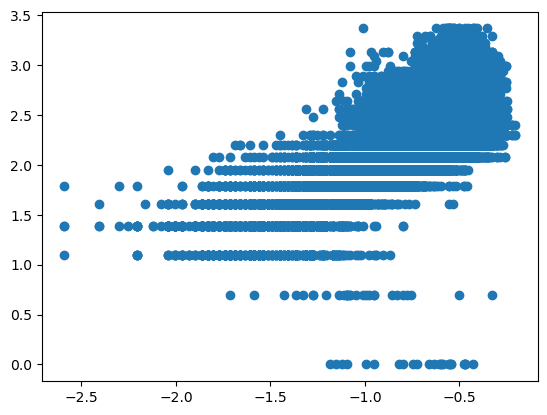

In [17]:
plt.scatter(df_log['length'], df_log['rings']);

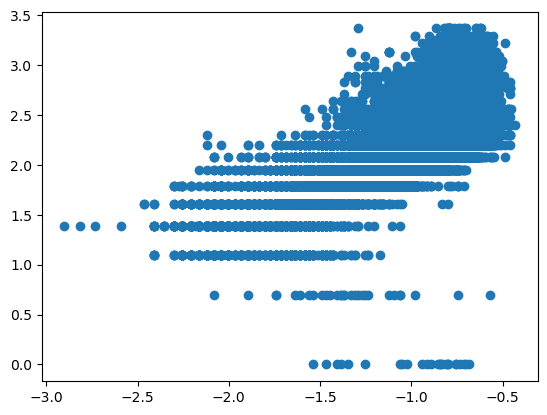

In [20]:
plt.scatter(df_log['diameter'], df_log['rings']);

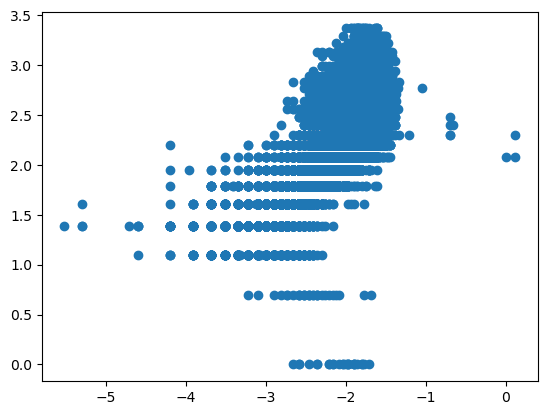

In [19]:
plt.scatter(df_log['height'], df_log['rings']);

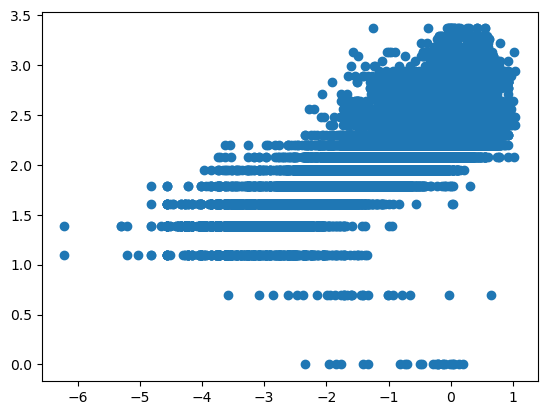

In [18]:
plt.scatter(df_log['whole_weight'], df_log['rings']);

In [ ]:
#Oh, in retrospect that would have been very interesting to view earlier... as notice that for all (save height) they're essetially
#the same in structure... Even height is mimics the '<' esque shape, albeit more squished.

In [ ]:
#First up will be getting together the dataframes

In [32]:
#In retrospect shoudl chang the names into tables_df, tables_parts, etc.

borders = [float('-inf'), -4, -3, -2, -1, 0, float('inf')]
modeling_feature_focus = 'whole_weight'
names_df = []

for i in range(len(borders)-1):
    names_df.append(f"df_log_part_{i}") #I think I'll need to do this in two parts

print(f"So, for the record, we'll be dealing with {len(names_df)} models.")
    
for i in range(len(names_df)):
    names_df[i] = df_log[df_log[modeling_feature_focus].between(borders[i],borders[i+1])]

So, for the record, we'll be dealing with 6 models.


In [36]:
parts_df = []
for i in range(len(names_df)):
    parts_df.append([])

for i in range(len(names_df)):
    parts_df[i].append(f"X_{i}")
    parts_df[i].append(f"y_{i}")
    parts_df[i].append(f"X_train_{i}")
    parts_df[i].append(f"X_test{i}")
    parts_df[i].append(f"y_train{i}")
    parts_df[i].append(f"y_test{i}")
    #Then we'll re-use pthe earlier X_trains: parts_df[i][2,3]

In [39]:
for i in range(len(parts_df)):
    parts_df[i][0] = names_df[i].drop('rings', axis=1)
    parts_df[i][1] = names_df[i]['rings']
    
    parts_df[i][2],  parts_df[i][3], parts_df[i][4], parts_df[i][5] = train_test_split(parts_df[i][0], parts_df[i][1],
                                                                                      test_size=.2, random_state=26)
    
    mms = MinMaxScaler()
    parts_df[i][2] = mms.fit_transform(parts_df[i][2])
    parts_df[i][3] = mms.transform(parts_df[i][3])

In [46]:
#I'll jump ahead to Random Forests:

models_df = []
for i in range(len(names_df)):
    models_df.append([])
for i in range(len(names_df)):
    models_df[i].append(f"model_part_{i}")
    models_df[i].append(f"preds_part_{i}")

#Names are prepared,so now let's do it
for i in range(len(models_df)):
    rf = RandomForestRegressor(random_state=26)
    
    models_df[i][0] = rf.fit(parts_df[i][2], parts_df[i][4])
    
    models_df[i][1] = models_df[i][0].predict(parts_df[i][3])

    #Oh,just realized that when logging I don't need tow ory aobut this... oh well
#     for i in range(len(preds_model_defaults_m)):
#         if preds_model_defaults_m[i] < 0:
#             preds_model_defaults_m[i] = 0
#     print(preds_model_defaults_m[preds_model_defaults_m<0])

    print(models_df[i][0].score(parts_df[i][2], parts_df[i][4]), models_df[i][0].score(parts_df[i][3], parts_df[i][5]))
    print(f"{root_mean_squared_log_error(parts_df[i][5], models_df[i][1])} is the rmsle of part {i}")
    print(f"~"*26)

0.8188718274792733 -0.08382218999955282
0.0745495936418762 is the rmsle of part 0
~~~~~~~~~~~~~~~~~~~~~~~~~~
0.856127727657888 -0.03778900437357513
0.08773108842288006 is the rmsle of part 1
~~~~~~~~~~~~~~~~~~~~~~~~~~
0.87267755749959 0.09484857232620758
0.0804909790762586 is the rmsle of part 2
~~~~~~~~~~~~~~~~~~~~~~~~~~
0.8844003182368578 0.15465297274482692
0.06873708007002009 is the rmsle of part 3
~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9275421216784645 0.472640740080136
0.052176412403794545 is the rmsle of part 4
~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9279486894049043 0.48617560548191985
0.04989946341253668 is the rmsle of part 5
~~~~~~~~~~~~~~~~~~~~~~~~~~


Unsurprising that the R^2 is so poor on the first few as their size is so small that the model had an incredibly hard time predicting them.

So, effectively we probably totally ostrocized the 'outliers', but perhaps we'll make that up with the rest.

So, let us continue with a similar procedure to above for the test/validation data: